<a href="https://colab.research.google.com/github/nsubbaian/FrequentistML/blob/master/Project4/FML_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 4: xTreme Gradient Boosted Trees**

Using out of the box package for xTreme gradient boosting trees: https://xgboost.readthedocs.io/en/latest/.


In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
SEED = 42

# Selected Dataset: http://archive.ics.uci.edu/ml/datasets/Forest+Fires
# Dataset Description: https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.names
# Chosen so it's good for regression (with numerical, not categorical features, and the target is a continuous number)

dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

# removed categorical feautures
dataset = dataset.drop(columns = {'month', 'day'})

# Shuffle and then split training data into 80% train, 10% validation and 10% test
training, validation, test = np.split(dataset.sample(frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])
print("Length of dataset:", len(dataset))
print( "Length of training:", len(training))
print("Length of validation:", len(validation))
print("Length of test:", len(test))

training.head()

Length of dataset: 517
Length of training: 413
Length of validation: 52
Length of test: 52


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
496,4,5,96.2,175.5,661.8,16.8,32.6,26,3.1,0.0,2.77
110,4,4,85.9,19.5,57.3,2.8,13.7,43,5.8,0.0,0.00
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00
265,4,4,93.7,102.2,550.3,14.6,22.1,54,7.6,0.0,0.79
225,4,4,93.5,149.3,728.6,8.1,22.9,39,4.9,0.0,48.55


best lambda 30
TEST MSE 1.5731854177272309


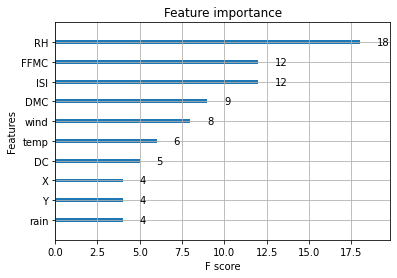

In [167]:
XGBtrain_X, XGBtrain_Y = training.iloc[:, :10], np.log(training.iloc[:, 10]+ 1)
XGBval_X, XGBval_Y = validation.iloc[:, :10], np.log(validation.iloc[:, 10]+1)
XGBtest_X, XGBtest_Y = test.iloc[:, :10], np.log(test.iloc[:, 10]+1)

dtrain = xgb.DMatrix(XGBtrain_X, label=XGBtrain_Y)
dtest = xgb.DMatrix(XGBtest_X, label=XGBtest_Y)
dval = xgb.DMatrix(XGBval_X, XGBval_Y)

# tune your regression method
bestMSE = float('inf')
for lam in [1e-15, 1e-5, .1, 1, 5, 10, 11, 12, 13, 14, 15, 16, 17, 20, 25, 30, 35, 50, 100]:
  param = {'max_depth': 6, 'min_child_weight': .3, 'eta': 1, 
          'objective': 'reg:squarederror',
          'reg_alpha' : lam}
  evallist = [(dtrain, 'train'), (dval, 'val')]

  # uses early stopping to find the optimal number of boosting rounds
  bst = xgb.train(param, dtrain, num_boost_round = 50, evals = evallist, 
                  early_stopping_rounds = 10, verbose_eval = False)
  
  XGBMSE = bst.best_score
  if (XGBMSE < bestMSE):
    bestLambda = lam
    bestMSE = XGBMSE
print("best lambda", bestLambda)


# Report your performance and output the feature importance.
param = {'max_depth': 6, 
          'min_child_weight': 1,
          'eta': .3, 
          'objective': 'reg:squarederror',
          'reg_alpha' : bestLambda}
evallist = [(dtrain, 'train'), (dval, 'val')]
bst = xgb.train(param, dtrain, num_boost_round = 50, evals = evallist, 
                early_stopping_rounds = 10, verbose_eval = False)


ypred = bst.predict(xgb.DMatrix(XGBtest_X), ntree_limit=bst.best_ntree_limit)
XGBMSE_test = np.square(np.subtract(XGBtest_Y, ypred)).mean()
print("TEST MSE", XGBMSE_test)

# 
xgb.plot_importance(bst)


Do the features reported make sense? If you are using the same dataset from assignment 1 or 2, do they agree with what you discovered using the Lasso penalty?

For this assignment I used the same dataset as I did in Assignment 1. The features reported do make sense for feature importance as RH is relative humidity in %: 15.0 to 100, according to https://www.nwcg.gov/ . However, these features are not the same as the features with the highest coefficients for Lasso Regression in Assignment 1. However, RH was one of the four chosen features that predicted small forest fires the best in http://www3.dsi.uminho.pt/pcortez/fires.pdf . 

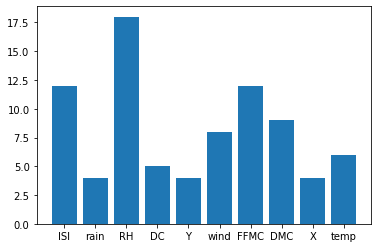

In [168]:
# plot - ‘weight’: the number of times a feature is used to split the data across all trees.
feat_imp = bst.get_score(importance_type='weight')
pyplot.bar(feat_imp.keys(), feat_imp.values())
pyplot.show()

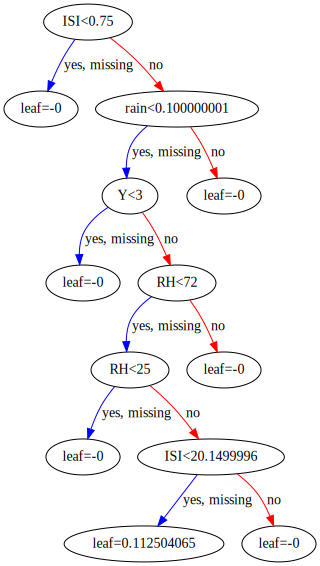

In [169]:
xgb.to_graphviz(bst, num_trees=2)